In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Visualizing an image data set sample

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


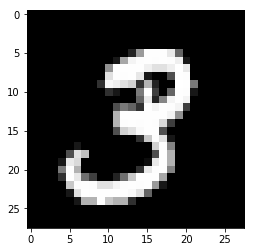

In [5]:
img = mnist.train.images[1]
label = mnist.train.labels[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print(label)


Defining the network 

In [6]:
def conv_net(inputs):
    conv = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)
    
    conv = tf.layers.max_pooling2d(conv,(2,2), (2,2), padding='same')

    conv = tf.layers.conv2d(conv, 64, (5,5), padding='same', activation=tf.nn.relu)

    conv = tf.layers.max_pooling2d(conv,(2,2), (2,2), padding='same')
        
    conv = tf.contrib.layers.flatten(conv)
    
    conv = tf.contrib.layers.fully_connected(conv, 1024, activation_fn=tf.nn.relu)
        
    conv = tf.contrib.layers.fully_connected(conv, 10, activation_fn=None)

    return conv

In [7]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='x')
y = tf.stop_gradient(tf.placeholder(dtype=tf.float32, shape=[None, 10], name='y'))

logits = conv_net(x)

logits = tf.identity(logits, name='logits')

predictions = tf.nn.softmax(logits, name='predictions')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Network training hyper parameters

In [8]:
epochs = 70
batch_size = 512

Training network

In [9]:
#Training helper functions    

def train_neural_network(session, optimizer, feature_batch, label_batch):
    session.run(optimizer, feed_dict={
        x: feature_batch,
        y: label_batch
    })
    
def print_training_stats(session, epoch, feature_batch, label_batch, validation_feature, validation_label, cost, accuracy):
    loss = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch })
    validation_accuracy = sess.run(accuracy, feed_dict={
                x: validation_feature,
                y: validation_label })
    print('Epoch {:>2}, Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(epoch + 1, loss, validation_accuracy))
    

In [11]:
save_model_path = './numbers_network_model'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            batch_features = batch[0].reshape((-1, 28, 28, 1))
            batch_labels = batch[1]
            train_neural_network(sess, optimizer, batch_features, batch_labels)
            
        print_training_stats(sess, epoch, batch_features, batch_labels, 
                             mnist.validation.images.reshape((-1, 28, 28, 1)), mnist.validation.labels,
                             cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    sess.close()

Training...
Epoch  1, Loss:     1.9231 Validation Accuracy: 0.775200
Epoch  2, Loss:     1.2248 Validation Accuracy: 0.806400
Epoch  3, Loss:     0.7682 Validation Accuracy: 0.844400
Epoch  4, Loss:     0.6209 Validation Accuracy: 0.870200
Epoch  5, Loss:     0.4505 Validation Accuracy: 0.889600
Epoch  6, Loss:     0.4127 Validation Accuracy: 0.905600
Epoch  7, Loss:     0.3258 Validation Accuracy: 0.912800
Epoch  8, Loss:     0.3315 Validation Accuracy: 0.922400
Epoch  9, Loss:     0.3289 Validation Accuracy: 0.928200
Epoch 10, Loss:     0.3345 Validation Accuracy: 0.931600
Epoch 11, Loss:     0.1913 Validation Accuracy: 0.937600
Epoch 12, Loss:     0.2912 Validation Accuracy: 0.941600
Epoch 13, Loss:     0.1835 Validation Accuracy: 0.945800
Epoch 14, Loss:     0.2209 Validation Accuracy: 0.946800
Epoch 15, Loss:     0.2441 Validation Accuracy: 0.950200
Epoch 16, Loss:     0.2250 Validation Accuracy: 0.953600
Epoch 17, Loss:     0.2037 Validation Accuracy: 0.955200
Epoch 18, Loss:    

Testing the model predictions

In [14]:
# Testing helpers

def display_image_predictions(features, labels, predictions, n_classes):
   
    label_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]
        axies[image_i][0].imshow(feature.reshape((feature.shape[0],feature.shape[1])))
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


INFO:tensorflow:Restoring parameters from ./numbers_network_model
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
INFO:tensorflow:Restoring parameters from ./numbers_network_model
Testing Accuracy: 0.9854029605263158



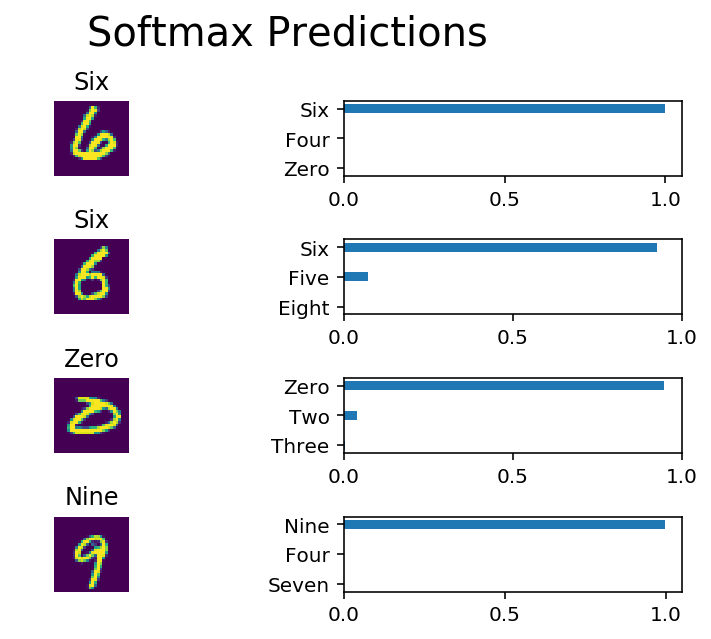

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

n_samples = 4
top_n_predictions = 3
save_model_path = './numbers_network_model'
meta_path = save_model_path + '.meta'
pb_model_name = 'mnist_model.pb'

def save_pb_model():
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(meta_path)
        loader.restore(sess, save_model_path)

        frozen_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            loaded_graph.as_graph_def(),
            ['predictions'])

        with open(pb_model_name, 'wb') as f:
            f.write(frozen_graph_def.SerializeToString())
        sess.close()

def test_model():
    
    test_features = mnist.test.images.reshape((-1, 28, 28, 1))
    test_labels = mnist.test.labels
    
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(meta_path)
        loader.restore(sess, save_model_path)
        
        # Getting Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for i in range(mnist.test.num_examples//batch_size):
            batch = mnist.test.next_batch(batch_size)
            test_feature_batch = batch[0].reshape((-1, 28, 28, 1))
            test_label_batch = batch[1]
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch })
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels })
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, 10)
        sess.close()
        
save_pb_model()
test_model()
    